In [1]:
%pip install torch torchvision transformers diffusers datasets accelerate torchmetrics torch-fidelity torchmetrics[image]

In [2]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

C:\Users\tomma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),  # Flatten the output
    torch.nn.Linear(768, 256),  # Adjust the input features to match flattened output
    torch.nn.ReLU(),
    torch.nn.Linear(256, 1),
    torch.nn.Sigmoid()
)


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
teacher_model = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", safety_checker=None, torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)

student_model = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", safety_checker=None, torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

Loading pipeline components...: 100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


In [6]:
# Move models to the chosen device
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [7]:
# Set up the loss functions for the student model

# def adversarial_loss_function(y_pred, y_true):
#     return torch.nn.functional.relu(1 - y_pred * y_true)

# def student_loss_function(y_pred, y_true):
#     return - y_pred * y_true

# # Hinge loss for adversarial loss
# adversarial_loss_function.requires_gradient = True

# MSE loss for distillation loss

adversarial_loss_function = torch.nn.BCELoss()

distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True
l = 5

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.1)

# Set up the optimizer for the discriminator model
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.000001)

In [8]:
import pandas as pd
from datasets import Dataset

file_path = 'dataset/dataset.json'

# Load the JSON file into a DataFrame
dataset = pd.read_json(file_path)
dataset = Dataset.from_pandas(dataset)

#split the dataset into train and validation
dataset = dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and test
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)

Dataset({
    features: ['image', 'caption'],
    num_rows: 295876
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 239659
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 29588
})
Dataset({
    features: ['image', 'caption'],
    num_rows: 26629
})


In [9]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((768, 768)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

torch.Size([3, 768, 768])


In [10]:
#Function to show an image tensor
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

#Function to perform a noise diffusion on an image
def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

Epoch 1, Batch Caption: A small herd of sheep gathered near a building to rest.


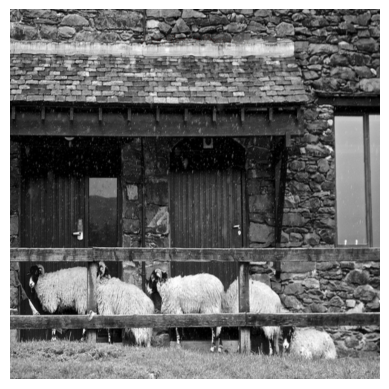

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


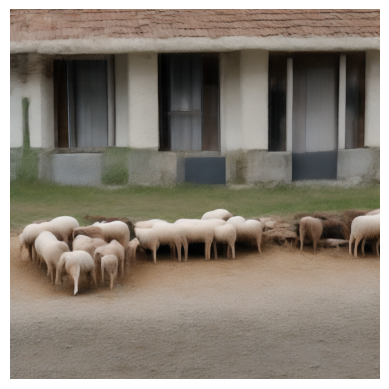

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


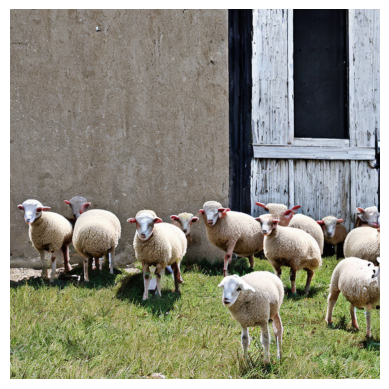

real pred = (tensor([[0.6182]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.6181727051734924]
Discriminator real Loss: 0.48098739981651306
type of discriminator_real_loss = <class 'torch.Tensor'>


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


student pred = (tensor([[0.4990]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.49903038144111633
Discriminator Fake Loss: 0.6912097930908203
Student Loss: 0.6950883269309998
Adversarial Loss: 0.5860986113548279
Distillation Loss: 0.0846581906080246
computing the CS score...
clip_score = 22.805448532104492
End of batch processing.

Epoch 2, Batch Caption: A child who is playing tea ball outside.


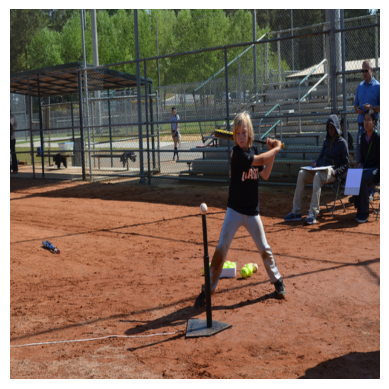

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


KeyboardInterrupt: 

In [11]:
import torch
from torchmetrics.multimodal.clip_score import CLIPScore
import os
import pickle
import shutil

CLIPmetric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16")

save_directory = "saved_data"

if os.path.exists(save_directory):
    shutil.rmtree(save_directory)
    print(f"Deleted existing folder: saved_data")
else:
    print(f"No existing folder found at: saved_data")
    os.makedirs(save_directory)

i=0

for batch in train_dataset:

    i+=1

    image = url_to_tensor(batch["image"])
    caption = batch["caption"]

    # Creating labels for real and fake images
    valid = torch.ones(image.size(0), 1)
    fake = torch.zeros(image.size(0), 1)
    real_image = image

    # Displaying the base image and its caption
    print(f"Epoch {i}, Batch Caption: {caption}")
    show_tensor_image(real_image)

    # Forward diffusion step
    print("Performing forward diffusion...")
    diffused_image = forward_noise(image, a=0.5, s=0.5, num_diffusion_steps=50)

    # Transforming images for distillation loss calculation
    transform = transforms.ToTensor()

    # Generating student image
    print("Generating student image...")
    student_image = student_model(caption, image=diffused_image, height=768, width=768, num_inference_steps=4).images[0]
    student_image_tensor = transform(student_image)
    show_tensor_image(student_image_tensor)

    # Forward diffusion on student image
    print("Forward diffusion on student image...")
    new_diffused_image = forward_noise(student_image, a=0.5, s=0.5, num_diffusion_steps=50)

    # Generating teacher image
    print("Generating teacher image...")
    teacher_image = teacher_model(caption, image=new_diffused_image, height=768, width=768, num_inference_steps=100).images[0]
    teacher_image_tensor = transform(teacher_image)
    show_tensor_image(teacher_image_tensor)

    # Discriminator predictions and loss for real image
    real_pred = discriminator_processor(image, do_rescale=False, return_tensors="pt")
    real_pred = discriminator_model(**real_pred, return_dict=False)

    print(f"real pred = {real_pred}")
    print(f"real_pred[0][0][0] = {real_pred[0][0][0]}]")

    discriminator_real_loss = adversarial_loss_function(real_pred[0][0][0], torch.tensor(1.))
    print(f"Discriminator real Loss: {discriminator_real_loss}")

    # Discriminator predictions and loss for student image
    student_pred = discriminator_processor(student_image, return_tensors="pt")
    student_pred = discriminator_model(**student_pred, return_dict=False)

    print(f"student pred = {student_pred}")
    print(f"student_pred[0][0][0] = {student_pred[0][0][0]}")

    discriminator_fake_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(0.))
    student_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(1.))

    print(f"Discriminator Fake Loss: {discriminator_fake_loss}")
    print(f"Student Loss: {student_loss}")

    # Calculating adversarial loss
    adversarial_loss = (discriminator_real_loss + discriminator_fake_loss)/2
    print(f"Adversarial Loss: {adversarial_loss}")

    # Computing distillation loss
    distillation_loss = distillation_loss_function(student_image_tensor, teacher_image_tensor)
    distillation_loss.requires_grad = True
    print(f"Distillation Loss: {distillation_loss}")

    #compute the CS score
    print("computing the CS score...")
    clip_score = CLIPmetric(student_image_tensor, caption)
    clip_score.detach()

    print(f"clip_score = {clip_score}")

    # Backpropagation for student model
    student_optimizer.zero_grad()
    student_total_loss = student_loss + l*distillation_loss
    student_total_loss.backward(retain_graph=True)
    student_optimizer.step()

    # Backpropagation for discriminator model
    discriminator_model_optimizer.zero_grad()
    adversarial_loss.backward()
    discriminator_model_optimizer.step()

    # Save real_image and student_image_tensor
    torch.save(real_image, os.path.join(save_directory, f'real_image_{i}.pt'))
    torch.save(student_image_tensor, os.path.join(save_directory, f'student_image_{i}.pt'))

    # Append new losses to the loss files
    with open(os.path.join(save_directory, 'student_losses.pkl'), 'ab') as f:
        pickle.dump([student_loss.item()], f)
    with open(os.path.join(save_directory, 'discriminator_real_losses.pkl'), 'ab') as f:
        pickle.dump([discriminator_real_loss.item()], f)
    with open(os.path.join(save_directory, 'discriminator_fake_losses.pkl'), 'ab') as f:
        pickle.dump([discriminator_fake_loss.item()], f)
    with open(os.path.join(save_directory, 'adversarial_losses.pkl'), 'ab') as f:
        pickle.dump([adversarial_loss.item()], f)
    with open(os.path.join(save_directory, 'distillation_losses.pkl'), 'ab') as f:
        pickle.dump([distillation_loss.item()], f)
    with open(os.path.join(save_directory, 'clip_scores.pkl'), 'ab') as f:
        pickle.dump([clip_score.item()], f)

    if (i%256 == 0):
        break

    print("End of batch processing.\n")


In [ ]:
import matplotlib.pyplot as plt
import torch
import pickle
import glob

# Function to load loss data from pickle files
def load_loss_data(filename):
    data = []
    with open(filename, 'rb') as f:
        while True:
            try:
                data.extend(pickle.load(f))
            except EOFError:
                break
    return data

# Load and plot loss data
print("Displaying learning graphs...")

student_losses = load_loss_data(os.path.join(save_directory, 'student_losses.pkl'))
plt.plot(student_losses, label="student_loss")

discriminator_real_losses = load_loss_data(os.path.join(save_directory, 'discriminator_real_losses.pkl'))
plt.plot(discriminator_real_losses, label="discriminator_real_loss")

discriminator_fake_losses = load_loss_data(os.path.join(save_directory, 'discriminator_fake_losses.pkl'))
plt.plot(discriminator_fake_losses, label="discriminator_fake_loss")

adversarial_losses = load_loss_data(os.path.join(save_directory, 'adversarial_losses.pkl'))
plt.plot(adversarial_losses, label="adversarial_loss")

distillation_losses = load_loss_data(os.path.join(save_directory, 'distillation_losses.pkl'))
plt.plot(distillation_losses, label="distillation_loss")
plt.legend()
plt.show()

clip_scores = load_loss_data(os.path.join(save_directory, 'clip_scores.pkl'))
plt.plot(clip_scores, label="clip_score")
plt.legend()
plt.show()
print("...done")

# Compute the frechet inception distance
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)

# Function to load image tensors
def load_image_tensors(pattern):
    files = glob.glob(pattern)
    tensors = [torch.load(file) for file in sorted(files)]
    return torch.stack(tensors)

real_images = load_image_tensors(os.path.join(save_directory, 'real_image_*.pt'))
print(real_images.shape)

student_images = load_image_tensors(os.path.join(save_directory, 'student_image_*.pt'))
print(student_images.shape)

fid.update(real_images, real=True)
fid.update(student_images, real=False)

print(f"FID: {float(fid.compute())}")